In [79]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from IPython.display import clear_output

# Data Preparation

In [3]:
data = pd.read_csv('pd_speech_features.csv')
data.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


## Correlation
<p>Let's check feature-class correlation distribution</p>

Text(0.5, 1.0, 'Feature-class correlation distribution')

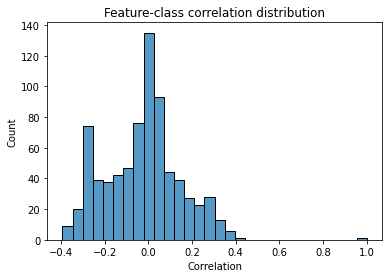

In [378]:
c = data.corr()['class']
ax = sns.histplot(c.values)
ax.set_xlabel('Correlation')
ax.set_title('Feature-class correlation distribution')

<p>Almost a normal distribution. There are a lot of features with a correlation value close to 0; we don't want these features.</p>
<b>We will drop all the features with a correlation value between -0.1 and 0.1</b>

In [333]:
high_corr_features = c[c.abs()>0.1].index
high_corr_features

Index(['id', 'gender', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'locPctJitter', 'locAbsJitter', 'rapJitter',
       ...
       'tqwt_kurtosisValue_dec_25', 'tqwt_kurtosisValue_dec_26',
       'tqwt_kurtosisValue_dec_27', 'tqwt_kurtosisValue_dec_28',
       'tqwt_kurtosisValue_dec_29', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35',
       'tqwt_kurtosisValue_dec_36', 'class'],
      dtype='object', length=392)

In [334]:
X = data[high_corr_features.to_list()].drop(['id', 'class'], axis=1)
#X = data.drop(['id', 'class'], axis=1)
y = data['class']
X.shape

(756, 390)

390 features are kept and will form X.

## Scaling X

In [335]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Splitting

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle=True, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(529, 390) (227, 390)


In [115]:
def split(X, y):
    return train_test_split(X, y, shuffle=True, test_size=0.3, random_state=0)

## Class distribution

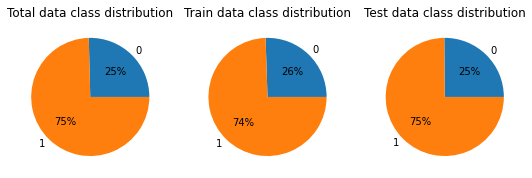

In [166]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.title('Total data class distribution')
y_unique, y_counts = np.unique(y, return_counts=True)
plt.pie(y_counts, labels=y_unique, autopct='%.0f%%')
plt.subplot(1, 3, 2)
plt.title('Train data class distribution')
y_unique, y_counts = np.unique(y_train, return_counts=True)
plt.pie(y_counts, labels=y_unique, autopct='%.0f%%')
plt.subplot(1, 3, 3)
plt.title('Test data class distribution')
y_unique, y_counts = np.unique(y_test, return_counts=True)
plt.pie(y_counts, labels=y_unique, autopct='%.0f%%')
plt.show()

### Note
<p>A constant model that always outputs "1" for any given input, will reach <b>74% accuracy</b> on the train data and <b>75% accuracy</b> on the test data.</p>

In [201]:
# Base function for cross validation and grid search hyperparameter tunning
def do_gridsearch_cv(parameters, base_estimator, model_name, overall_results):
    clf = GridSearchCV(base_estimator, parameters, cv=10, return_train_score=True)
    clf.fit(X_train, y_train)
    print('---'+model_name+'---')
    print('Best parameters:')
    print(clf.best_params_)
    print('Best Test Score:')
    print(clf.best_score_)
    overall_results[model_name]['CV_Best'] = clf.best_score_
    print('Best Train Score:')
    print(max(clf.cv_results_['mean_train_score']))
    overall_results[model_name]['Train_Best'] = max(clf.cv_results_['mean_train_score'])
    return clf.best_estimator_, pd.DataFrame(clf.cv_results_)

In [50]:
# testing a model on the test-set
# confusion matrix
def eval_model(model, model_name, overall_results):
    print("Evaluating test set on", model_name)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    per = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("Precision:", per)
    print("Recall:", rec)
    print("F1:", f1)
    overall_results[model_name]['Test_Accuracy'] = acc
    overall_results[model_name]['Test_Precision'] = per
    overall_results[model_name]['Test_Recall'] = rec
    overall_results[model_name]['Test_F1'] = f1
    matrix = confusion_matrix(y_test, y_pred)
    labels = list(range(len(matrix)))
    matdf = pd.DataFrame(matrix, index=labels, columns=labels)
    return matdf

In [170]:
overall_results = {}

# GridSearch and Cross validation

## DecisionTree

In [337]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}
overall_results['DecisionTree'] = {}
dectree = DecisionTreeClassifier()
best_dectree, results = do_gridsearch_cv(parameters, dectree, 'DecisionTree', overall_results)

---DecisionTree---
Best parameters:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': None, 'splitter': 'best'}
Best Test Score:
0.8280478955007258
Best Train Score:
1.0


In [338]:
eval_model(best_dectree, 'DecisionTree', overall_results)

Evaluating test set on DecisionTree
Accuracy: 0.7841409691629956
Precision: 0.8579881656804734
Recall: 0.8529411764705882
F1: 0.8554572271386431


,0,1
0,33,24
1,25,145


<p>Model test accuracy is lower than cross validation accuracy by 4%, i.e. 78% wich is very close to the constant model accuracy (75%)</p>
<b>Not so good</b>

## KNN

In [339]:
parameters = {
    'n_neighbors': list(range(1, 10)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
overall_results['KNN'] = {}
knn = KNeighborsClassifier()
best_knn, results = do_gridsearch_cv(parameters, knn, 'KNN', overall_results)

---KNN---
Best parameters:
{'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}
Best Test Score:
0.926233671988389
Best Train Score:
1.0


In [340]:
eval_model(best_knn, 'KNN', overall_results)

Evaluating test set on KNN
Accuracy: 0.9295154185022027
Precision: 0.9529411764705882
Recall: 0.9529411764705882
F1: 0.9529411764705882


,0,1
0,49,8
1,8,162


<p>KNN reached average 92.6% accuracy on cross validation and 92.9% on test data.</p>
<b>Pretty good resutls</b>

# SVM

In [341]:
parameters = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['auto', 'scale'],
    'class_weight': [None, 'balanced']
}
overall_results['SVM'] = {}
svm = SVC()
best_svm, results = do_gridsearch_cv(parameters, svm, 'SVM', overall_results)

---SVM---
Best parameters:
{'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Best Test Score:
0.8752177068214804
Best Train Score:
1.0


In [342]:
eval_model(best_svm, 'SVM', overall_results)

Evaluating test set on SVM
Accuracy: 0.8766519823788547
Precision: 0.927710843373494
Recall: 0.9058823529411765
F1: 0.9166666666666667


,0,1
0,45,12
1,16,154


<p>not so bad, cross validation score is equal to the test score; good generalization but KNN outperforms this.</p>

In [343]:
parameters = {
    'bootstrap': [True],
    'max_depth': [None, 20, 50, 100],
    'max_features': [2, 3],
    'n_estimators': [50, 100]
}
overall_results['RandomForest'] = {}
forest = RandomForestClassifier()
best_forest, results = do_gridsearch_cv(parameters, forest, 'RandomForest', overall_results)

---RandomForest---
Best parameters:
{'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'n_estimators': 50}
Best Test Score:
0.8753265602322207
Best Train Score:
1.0


In [344]:
eval_model(best_forest, 'RandomForest', overall_results)

Evaluating test set on RandomForest
Accuracy: 0.8590308370044053
Precision: 0.8631578947368421
Recall: 0.9647058823529412
F1: 0.9111111111111111


,0,1
0,31,26
1,6,164


In [345]:
overall = pd.DataFrame.from_dict(overall_results, orient='index')
overall['Mean'] = overall.mean(axis=1)
overall

,CV_Best,Train_Best,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Mean
DecisionTree,0.828048,1.0,0.784141,0.857988,0.852941,0.855457,0.863096
KNN,0.926234,1.0,0.929515,0.952941,0.952941,0.952941,0.952429
SVM,0.875218,1.0,0.876652,0.927711,0.905882,0.916667,0.917022
RandomForest,0.875327,1.0,0.859031,0.863158,0.964706,0.911111,0.912222


<p><b>KNN</b> outperformed the other 3. it is the only model that reached accuracies higher than 90%. The KNN model seems robust and its accuracy is 18% higher that the constant model; but it's not perfect and there is still room for improvements.</p>

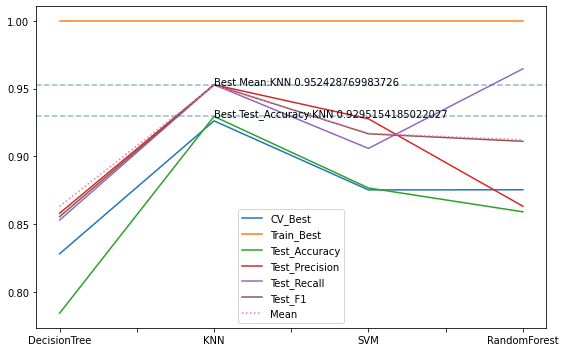

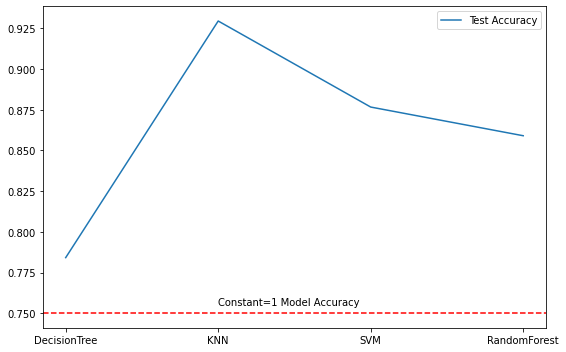

In [347]:
def plot_overall_results(overall):
    plt.figure(figsize=(8, 5))
    ax = overall.drop('Mean', axis=1).plot(ax=plt.gca())
    ax.plot(overall['Mean'], label='Mean', linestyle=':')
    for column in ['Test_Accuracy', 'Mean']:
        best = overall[column].argmax()
        ax.axhline(overall[column].max(), linestyle='--', alpha=0.5)
        ax.text('KNN', overall[column].max(),
        'Best {0}:'.format(column)+overall.index[best]+" {0}".format(overall[column].max()))
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(8, 5))
    plt.plot(overall.index, overall['Test_Accuracy'], label='Test Accuracy')
    plt.axhline(0.75, linestyle='--', color='red')
    plt.text('KNN', 0.755, 'Constant=1 Model Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_overall_results(overall)

In [357]:
def do_pca_search(model, to=100):
    X_train, X_test, y_train, y_test = split(X_scaled, y)
    base_score = cross_validate(tree, X_train, y_train, cv=10)['test_score'].mean()
    fe = pd.DataFrame(columns=['n_components', 'accuracy'])
    for i in range(2, int(to)):
        clear_output(wait=True)
        print(i)
        pca = PCA(n_components=i)
        X_decom = pca.fit_transform(X_scaled)
        X_train, X_test, y_train, y_test = split(X_decom, y)
        fe = fe.append(
            {'n_components': i,
             'accuracy': cross_validate(model, X_train, y_train, cv=10)['test_score'].mean()},
                ignore_index=True)
    clear_output()
    return base_score, fe

In [231]:
def visualize_pca_search_results(base_score, best_pca, results, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(results['n_components'], results['accuracy'])
    plt.axhline(base_score, linestyle='--', color='orange')
    plt.text(results['n_components'].quantile(0.1), base_score, 'CV Score Without PCA')
    plt.axhline(best_pca['accuracy'], color='green')
    plt.text(results['n_components'].quantile(0.1), best_pca['accuracy'], 'Best CV Score Using PCA')
    plt.axhline(overall.loc[model_name]['CV_Best'], linestyle='--', color='red')
    plt.text(results['n_components'].quantile(0.1), overall.loc[model_name]['CV_Best'],
             'Tunned Model Best CV Score without PCA')

    plt.xlabel('PCA n_components')
    plt.ylabel('CV Mean Accuracy')
    plt.tight_layout()
    plt.show()

# PCA
<p>In order to use PCA as a mean for feature extraction:
    <ol>
        <li>We will first brute-force the PCA main parameter i.e. n_components using a raw instance of each algorithm (default parameters) and cross validation.</li>
        <li>After the best n_components value is found, we will perform a GridSearchCV using the transformed X, i.e. dimensionality reduced data, to find the optimal parameters.</li>
    </ol>
</p>

In [118]:
overall_pca = {}

## DecisionTree

In [348]:
dectree = DecisionTreeClassifier()
base_score, fe = do_pca_search(dectree, 200)
best_index = fe[fe.accuracy>base_score].sort_values(by='accuracy', ascending=False).index[0]
best_pca = fe.loc[best_index]
print('DecisionTree Best PCA Config:')
print('->n_components:',best_pca['n_components'])
print('->Accuracy:', best_pca['accuracy'])

DecisionTree Best PCA Config:
->n_components: 41.0
->Accuracy: 0.8166182873730043


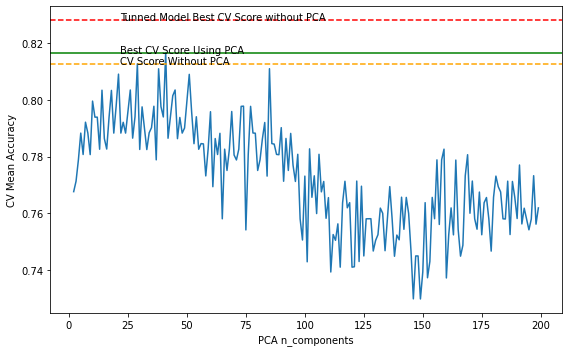

In [349]:
visualize_pca_search_results(base_score, best_pca, fe, 'DecisionTree')

<p>PCA barely improved the accuracy, almost every cross validation performed using PCA, resulted in a accuracy <b>lower</b> that the non-PCA accuracy.</p> 

In [350]:
n_components = best_pca.n_components.astype('int')
pca = PCA(n_components=n_components)
X_decom = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = split(X_decom, y)
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}
overall_pca['DecisionTree'] = {}
dectree = DecisionTreeClassifier()
best_pca_dectree, results = do_gridsearch_cv(parameters, dectree, 'DecisionTree', overall_pca)

---DecisionTree---
Best parameters:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': None, 'splitter': 'random'}
Best Test Score:
0.797677793904209
Best Train Score:
1.0


In [351]:
eval_model(best_pca_dectree, 'DecisionTree', overall_pca)

Evaluating test set on DecisionTree
Accuracy: 0.73568281938326
Precision: 0.84375
Recall: 0.7941176470588235
F1: 0.8181818181818182


,0,1
0,32,25
1,35,135


<b>Test accuracy is lower that the constant-model accuracy by 2%</b>

# KNN

In [358]:
knn = KNeighborsClassifier()
base_score, fe = do_pca_search(knn, 150)
best_index = fe[fe.accuracy>base_score].sort_values(by='accuracy', ascending=False).index[0]
best_pca = fe.loc[best_index]
print('KNN Best PCA Config:')
print('->n_components:',best_pca['n_components'])
print('->Accuracy:', best_pca['accuracy'])

KNN Best PCA Config:
->n_components: 73.0
->Accuracy: 0.8600870827285922


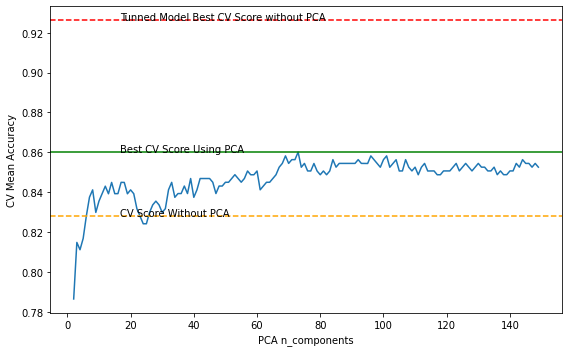

In [359]:
visualize_pca_search_results(base_score, best_pca, fe, 'KNN')

<p>Almost every cross validation performed using PCA data resulted in a accuracy value <b>higher</b> than the non-PCA accuracy. PCA does improve accuracy, but the non-PCA tunned KNN model is far better! we should wait and see what we get after performing GridSearch.</p>

In [360]:
n_components = best_pca.n_components.astype('int')
pca = PCA(n_components=n_components)
X_decom = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = split(X_decom, y)
parameters = {
    'n_neighbors': list(range(1, 10)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
overall_pca['KNN'] = {}
knn = KNeighborsClassifier()
best_pca_knn, results = do_gridsearch_cv(parameters, knn, 'KNN', overall_pca)

---KNN---
Best parameters:
{'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}
Best Test Score:
0.9186865021770683
Best Train Score:
1.0


In [361]:
eval_model(best_pca_knn, 'KNN', overall_pca)

Evaluating test set on KNN
Accuracy: 0.9162995594713657
Precision: 0.9467455621301775
Recall: 0.9411764705882353
F1: 0.943952802359882


,0,1
0,48,9
1,10,160


<p>Almost the same as the non-PCA KNN, slightly lower scores i.e. less than a percent.</p>

## SVM

In [362]:
svm = SVC()
base_score, fe = do_pca_search(svm, 150)
best_index = fe[fe.accuracy>base_score].sort_values(by='accuracy', ascending=False).index[0]
best_pca = fe.loc[best_index]
print('SVM Best PCA Config:')
print('->n_components:',best_pca['n_components'])
print('->Accuracy:', best_pca['accuracy'])

SVM Best PCA Config:
->n_components: 61.0
->Accuracy: 0.8714804063860668


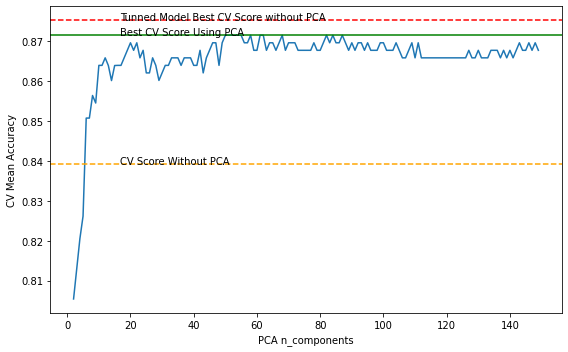

In [363]:
visualize_pca_search_results(base_score, best_pca, fe, 'SVM')

<p> PCA resulted in noticable performance improvement </p>

In [364]:
n_components = best_pca.n_components.astype('int')
pca = PCA(n_components=n_components)
X_decom = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = split(X_decom, y)
parameters = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['auto', 'scale'],
    'class_weight': [None, 'balanced']
}
overall_pca['SVM'] = {}
svm = SVC()
best_pca_svm, results = do_gridsearch_cv(parameters, svm, 'SVM', overall_pca)

---SVM---
Best parameters:
{'class_weight': None, 'gamma': 'auto', 'kernel': 'poly'}
Best Test Score:
0.8998185776487663
Best Train Score:
1.0


In [365]:
eval_model(best_pca_svm, 'SVM', overall_pca)

Evaluating test set on SVM
Accuracy: 0.9030837004405287
Precision: 0.9352941176470588
Recall: 0.9352941176470588
F1: 0.9352941176470588


,0,1
0,46,11
1,11,159


<p>PCA-applied SVM, outperformed the non-PCA version. but still not as good as the non-PCA KNN</p>

## RandomForest

In [366]:
forest = RandomForestClassifier()
base_score, fe = do_pca_search(forest, 100)
best_index = fe[fe.accuracy>base_score].sort_values(by='accuracy', ascending=False).index[0]
best_pca = fe.loc[best_index]
print('RandomForest Best PCA Config:')
print('->n_components:',best_pca['n_components'])
print('->Accuracy:', best_pca['accuracy'])

RandomForest Best PCA Config:
->n_components: 38.0
->Accuracy: 0.8772133526850509


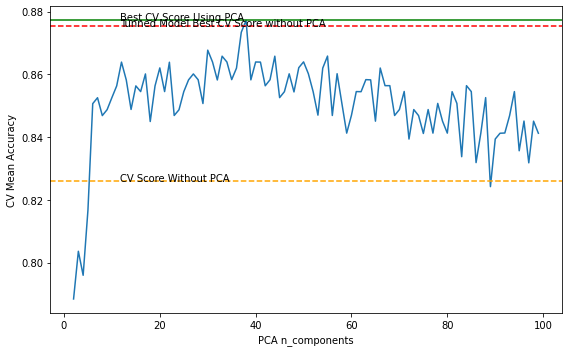

In [367]:
visualize_pca_search_results(base_score, best_pca, fe, 'RandomForest')

<p>Almost 5% cross validation accuracy improvement, not so bad, not great.</p>

In [368]:
n_components = best_pca.n_components.astype('int')
pca = PCA(n_components=n_components)
X_decom = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = split(X_decom, y)
parameters = {
    'bootstrap': [True],
    'max_depth': [None, 20, 50, 100],
    'max_features': [2, 3],
    'n_estimators': [50, 100]
}
overall_pca['RandomForest'] = {}
forest = RandomForestClassifier()
best_pca_forest, results = do_gridsearch_cv(parameters, forest, 'RandomForest', overall_pca)

---RandomForest---
Best parameters:
{'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'n_estimators': 50}
Best Test Score:
0.8564223512336719
Best Train Score:
1.0


In [369]:
eval_model(best_pca_forest, 'RandomForest', overall_pca)

Evaluating test set on RandomForest
Accuracy: 0.8502202643171806
Precision: 0.8434343434343434
Recall: 0.9823529411764705
F1: 0.9076086956521738


,0,1
0,26,31
1,3,167


<p>Not much different than the non-PCA RandomForest</p>

## Let's compare all the results
### PCA-Applied:

In [370]:
overall_pca_df = pd.DataFrame.from_dict(overall_pca, orient='index')
overall_pca_df['Mean'] = overall.mean(axis=1)
print("Final PCA Applied results")
overall_pca_df

Final PCA Applied results


,CV_Best,Train_Best,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Mean
DecisionTree,0.797678,1.0,0.735683,0.843750,0.794118,0.818182,0.863096
KNN,0.918687,1.0,0.916300,0.946746,0.941176,0.943953,0.952429
SVM,0.899819,1.0,0.903084,0.935294,0.935294,0.935294,0.917022
RandomForest,0.856422,1.0,0.850220,0.843434,0.982353,0.907609,0.912222


<ul>
    <li>
        DecisionTree <b>underperformed</b> the constant-model.
    </li>
    <li>
        KNN is the winner with 91.6% Test Accuracy.
    </li>
    <li>
        SVM reached 90% accuracy, outperforming its non-PCA version.
    </li>
   </ul>

In [371]:
print("Final non-PCA results")
overall

Final non-PCA results


,CV_Best,Train_Best,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Mean
DecisionTree,0.828048,1.0,0.784141,0.857988,0.852941,0.855457,0.863096
KNN,0.926234,1.0,0.929515,0.952941,0.952941,0.952941,0.952429
SVM,0.875218,1.0,0.876652,0.927711,0.905882,0.916667,0.917022
RandomForest,0.875327,1.0,0.859031,0.863158,0.964706,0.911111,0.912222


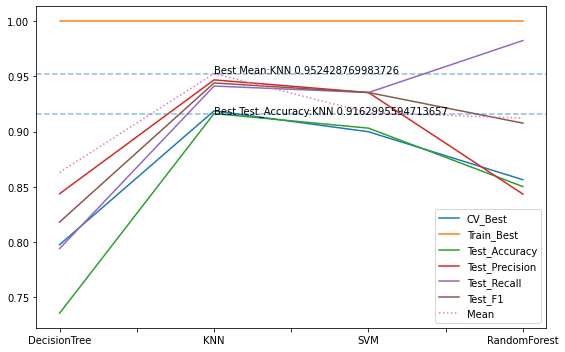

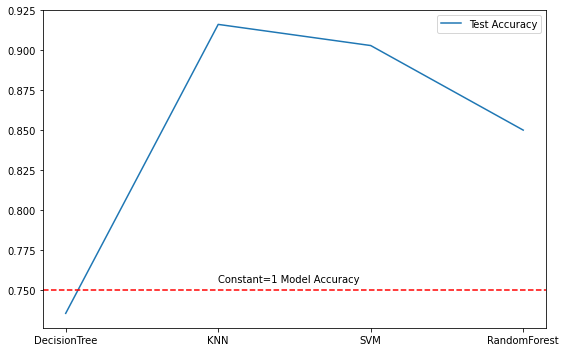

In [372]:
plot_overall_results(overall_pca_df)

# Final results in a plot

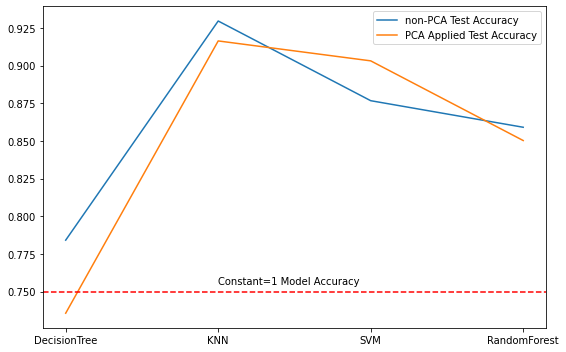

In [374]:
plt.figure(figsize=(8, 5))
plt.plot(overall.index, overall['Test_Accuracy'], label='non-PCA Test Accuracy')
plt.plot(overall.index, overall_pca_df['Test_Accuracy'], label='PCA Applied Test Accuracy')
plt.axhline(0.75, linestyle='--', color='red')
plt.text('KNN', 0.755, 'Constant=1 Model Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Winner?

<b>Here are the top 3 models</b>
<ol>
    <li><b>non-PCA KNN</b></li>
    <li><b>PCA-Applied KNN</b></li>
    <li><b>PCA-Applied SVM</b></li>
   </ol>
   